<a href="https://colab.research.google.com/github/euodiadodd1/Curriculum_Learning_For_Maths/blob/main/CL_Matrix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import gzip
import shutil
with gzip.open('/content/v05.gz', 'rb') as f_in:
    with open('v05.txt', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

In [2]:
import pandas as pd
import numpy as np
import ast

## PROCESS KREUSER SKARKE DATA

df = pd.read_csv("v05.txt", header=None)
data = df[0].str.split('   ', expand=True)

for i, x in enumerate(data[4]):
    if x and len(x.split('  ')) > 1:
      #print(x.split('  ')) 
      sl = [a for a in x.split('  ') if a]
      if len(sl) > 1:
        data[4][i] = sl[0]
      else:
        data[4][i] = sl[0]
    if x and len(x.split(' ')) > 1:
      #print(x.split('  ')) 
      sl = [a for a in x.split(' ') if a]
      if len(sl) > 1:
        data[4][i] = sl[0]
      else:
        data[4][i] = sl[0]

for i, x in enumerate(data[3]):
    if x and len(x.split(' ')) > 1:
      #print(x.split('  ')) 
      sl = [a for a in x.split(' ') if a]
      if len(sl) > 1:
        data[3][i] = sl[0]
        data[4][i] = sl[1]
      else:
        data[3][i] = sl[0]

for i, x in enumerate(data[2]):
    if x and len(x.split('  ')) > 1:
      print(i, x.split('  ')) 
      sl = [a for a in x.split('  ') if a]
      if len(sl) > 1:
        data[2][i] = sl[0]
        data[3][i] = sl[1]


data = data.drop(5, axis=1)
data = data.drop(0, axis=1)


for i, x in data.iterrows():
  if i%5 == 0:
    data = data.drop(i, axis=0)

data = data.reset_index(drop=True)

split = np.split(data[:6244], data.shape[0]//4)
arr = np.asarray([np.asarray(x).astype(int) for x in split])

labels = df[1].dropna().reset_index(drop=True)
print(labels)
for i, x in enumerate(labels):
  ls = x.split(' ')
  labels[i] = int(ast.literal_eval(ls[1])[0])



38 ['0', '10']
0           1 [40]
1         21 [-40]
2          1 [200]
3       101 [-200]
4          1 [204]
           ...    
1556     167 [-96]
1557     137 [240]
1558    257 [-240]
1559       143 [0]
1560       251 [0]
Name: 1, Length: 1561, dtype: object


In [3]:
## Split labels into 10 groups of increasing difficulty
label_bins = pd.cut(labels, 10, labels=range(10))
print(label_bins)


0       5
1       4
2       6
3       3
4       6
       ..
1556    4
1557    6
1558    3
1559    4
1560    4
Name: 1, Length: 1561, dtype: category
Categories (10, int64): [0 < 1 < 2 < 3 ... 6 < 7 < 8 < 9]


In [4]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn import svm
from sklearn import metrics


In [ ]:
from torch.utils.data import Dataset
from natsort import natsorted
from torchvision import datasets, transforms
from sklearn.decomposition import PCA
from sklearn import preprocessing

class CustomDataset(Dataset):
  def __init__(self, data, labels):
    self.data = data
    self.labels = labels
    self.transform = transforms.Compose([transforms.ToTensor()])

    #self.transform = transforms.Compose([transforms.ToTensor()])

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    data = self.data[idx]
    labels = self.labels[idx]



    if idx == self.__len__():  
            raise IndexError  
    #print(d.shape,l.shape)
    return self.transform(data), (labels)


In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor

## GENERATING AND PROCESSING DATASET OF MATRICES

## Pad matrices to the dimensions of the largest one
def to_shape(a, shape):
    y_, x_ = shape
    y, x = a.shape
    y_pad = (y_-y)
    x_pad = (x_-x)
    return np.pad(a,((y_pad//2, y_pad//2 + y_pad%2), 
                     (x_pad//2, x_pad//2 + x_pad%2)),
                  mode = 'constant')


num_samples = 5000
matrices = []
matrix_sizes = [25,50,100]
matrix_2  = np.random.uniform(-1.0, 1.0, (num_samples,matrix_sizes[0],matrix_sizes[0]))
matrix_5  = np.random.uniform(-1.0, 1.0, (num_samples,matrix_sizes[1],matrix_sizes[1]))
matrix_10 = np.random.uniform(-1.0, 1.0, (num_samples,matrix_sizes[2],matrix_sizes[2]))

#print(matrix_2[0].shape)
matrix_2 = [to_shape(x, (matrix_sizes[2],matrix_sizes[2])) for x in matrix_2]
matrix_5 = [to_shape(x, (matrix_sizes[2],matrix_sizes[2])) for x in matrix_5]

matrices.append(matrix_2)
matrices.append(matrix_5)
matrices.append(matrix_10)

sizes = np.concatenate([[i]*num_samples for i in matrix_sizes])

matrices = np.concatenate(matrices)
print(matrices.shape)
BATCH_SIZE = len(matrices)

labels = np.asarray([np.linalg.eig(m)[0] for m in matrices])
print(labels.shape)



(15000, 100, 100)


KeyboardInterrupt: ignored

In [5]:
class DatasetMaker(Dataset):
    def __init__(self, datasets):
        """
        datasets: a list of get_class_i outputs, i.e. a list of list of images for selected classes
        """
        self.datasets = datasets
        self.lengths = [len(d) for d in self.datasets]
        #self.transformFunc = transformFunc

    def __getitem__(self, i):
        class_label, index_wrt_class = self.index_of_which_bin(self.lengths, i)
        img = self.datasets[class_label][index_wrt_class]
        #img = self.transformFunc(img)
        return img, class_label

    def __len__(self):
        return sum(self.lengths)

    def index_of_which_bin(self, bin_sizes, absolute_index, verbose=False):
        """
        Given the absolute index, returns which bin it falls in and which element of that bin it corresponds to.
        """
        # Which class/bin does i fall into?
        accum = np.add.accumulate(bin_sizes)
        if verbose:
            print("accum =", accum)
        bin_index = len(np.argwhere(accum <= absolute_index))
        if verbose:
            print("class_label =", bin_index)
        # Which element of the fallent class/bin does i correspond to?
        index_wrt_class = absolute_index - np.insert(accum, 0, 0)[bin_index]
        if verbose:
            print("index_wrt_class =", index_wrt_class)

        return bin_index, index_wrt_class


In [6]:
## Adapted from https://gist.github.com/Miladiouss/6ba0876f0e2b65d0178be7274f61ad2f
# Separating trainset/testset data/label

split = 0.8
split_idx = int(split*len(labels))

## Switch to KS data
matrices = arr
sizes = label_bins
matrix_sizes = range(10)

x_train, y_train, sizes_train = matrices[:split_idx], labels[:split_idx], sizes[:split_idx]
x_test, y_test, sizes_test = matrices[split_idx:], labels[split_idx:], sizes[split_idx:]

print(len(sizes_test))
#x_test = testset.data
#y_test = testset.targets
#print(trainset[0])
# Define a function to separate CIFAR classes by class index


def get_class_i(x, y, i):
    """
    x: trainset.train_data or testset.test_data
    y: trainset.train_labels or testset.test_labels
    i: class label, a number between 0 to 9
    return: x_i
    """
    # Convert to a numpy array
    y = np.array(y)
    # Locate position of labels that equal to i
    pos_i = np.argwhere(y == i)
    #print(pos_i)
    # Convert the result into a 1-D list
    pos_i = list(pos_i[:, 0])
    # Collect all data that match the desired label
    #print(len(pos_i))
    x_i = [x[j] for j in pos_i]


    return x_i



313


In [7]:
def get_sized_datasets(matrix_sizes, sizes_train, sizes_test):
  
  train = []
  test = []
  for s in matrix_sizes:
    print(s)
    train.append(get_class_i(x_train, sizes_train, s))
    test.append(get_class_i(x_test, sizes_test, s))

  trainset = DatasetMaker(train)
  testset = DatasetMaker(test)

  # Create datasetLoaders from trainset and testset
  trainloader = DataLoader(
      trainset, batch_size=len(trainset), shuffle=False)
  testloader = DataLoader(
      testset, batch_size=len(testset), shuffle=False)
  
  return trainloader, testloader

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Hyperparameters for our network

# Build a feed-forward network
def make_model(input_size, hidden_sizes):
    model = nn.Sequential(#nn.Flatten(),
                          
                          nn.Linear(input_size, hidden_sizes[0]),
                          nn.ReLU(),
                          # nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                          # nn.ReLU(),
                          nn.Flatten(),
                          nn.Linear(32, 1)
                          
                      )
    return model
                      

In [9]:
## Pacing function

def data_pacing_function(data_set, batch_increase, increment, starting_percentage, curr_batch, current_pace, batch_size=100):

    X_train, y_train = data_set
    X_train = torch.unsqueeze(X_train, 1)
    #y_train = torch.unsqueeze(y_train, 0)
    #print("SHAPE", X_train.shape)
    
    data_size = X_train.shape[0]
    pace = current_pace

    if curr_batch % batch_increase == 0:
      if curr_batch == 0:
        pace = starting_percentage
        print(y_train.shape)
      else:
        pace = min(pace*increment, 1)

    pacing_idx = int(np.ceil(pace * data_size))
    #print(pacing_idx)

    new_X_train = X_train[:pacing_idx, :,:,:]
    new_y_train = y_train[:pacing_idx]

    return new_X_train, new_y_train, pace



In [10]:
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

In [11]:
np.random.seed(1)
def generate_random_batch(x, y, batch_size):
    size_data = x.shape[0]
    cur_batch_idxs = np.random.choice(size_data, batch_size, replace=False)
    return x[cur_batch_idxs, :, :, :], y[cur_batch_idxs]

In [12]:
def evaluate_model(X_img, y_test, model):
  accuracy = 0
  loss = 0
  model.eval()
  X_img, y_test = X_img, y_test
  with torch.no_grad():
    outputs = model(X_img)
    #accuracy = get_num_correct(outputs, y_test)/len(y_test)
    loss += criterion(outputs, y_test).item()
  model.train()
  return accuracy, loss/len(y_test)


In [63]:
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR

#net = make_model((batch_size,3,32,32), 100)
net = make_model(4, [8,16,32])

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

net.to(device)

criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=1e-3)

decayRate = 0.91
min_lr=1e-3
lr_batch_size = 100

#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=lr_batch_size, gamma=decayRate)

In [64]:
from random import sample

regime = "anti"
if regime == "curriculum":
  order = matrix_sizes
elif regime == "anti":
  order = matrix_sizes[::-1]
else:
  order = sample(matrix_sizes, len(matrix_sizes))

print(order)
trainloader, testloader = get_sized_datasets(order, sizes_train, sizes_test)


range(9, -1, -1)
9
8
7
6
5
4
3
2
1
0


In [65]:
train_set = next(iter(trainloader))
test_set = next(iter(testloader))

X_train, y_train = train_set
test_img, test_labels = test_set
test_img, test_labels = test_img.to(device).float(), test_labels.to(device).float()
#print(X_train.shape[0])

print(y_train.shape)

torch.Size([1248])


In [55]:
results = []


In [66]:
from torch.utils.tensorboard import SummaryWriter
tb = SummaryWriter()

current_pace = 1
total_correct = 0
accuracy = 0
running_num_samples = 0

#Reinitialise
#optimizer = optim.Adam(net.parameters(), lr=1e-2)

# decayRate = 0.91
# min_lr=1e-3
# lr_batch_size = 400
batch_increase = 10
batch_size = 1
increment = 1.01
starting_percentage = 0.04

metrics = {"curriculum": "", "sample_size": 0, "train_accuracy":[] , "test_accuracy":[], "train_loss":[], "test_loss":[], "batch":[]}

metrics["curriculum"] = regime


#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=lr_batch_size, gamma=decayRate)
running_loss = 0.0
for batch in range(5*len(X_train)):  # loop over the dataset multiple times

    
    X, y, current_pace = data_pacing_function(train_set, batch_increase, increment, starting_percentage, batch, current_pace, batch_size)
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = generate_random_batch(X, y, batch_size)

    #print("label:", labels)

    inputs, labels = inputs.to(device).float(), labels.to(device).float()
    labels = torch.unsqueeze(labels,1)

    #print(inputs.shape, labels.shape)
    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = net(inputs)

    #print("preds:", inputs, "label:", labels)
    #print("outputs", outputs.shape, labels.shape)
    loss = criterion(outputs, labels)
    total_correct += get_num_correct(outputs, labels)
    loss.backward()
    optimizer.step()
    #
    
    # print statistics
    running_loss += loss.item()
    running_num_samples += len(labels)
    #print(scheduler.get_last_lr())

    # if scheduler.get_last_lr()[0] > min_lr:
    #   scheduler.step()

    #print("correct:", total_correct)
    if batch % 100 == 99:    # print every 2000 mini-batches
      print(f'[{batch + 1}] loss: {running_loss/running_num_samples:.3f} pace: {current_pace} data_size: {len(y)}')
    # losses.append(running_loss)
    #     running_loss = 0.0
    if batch % 50 == 49: 
      test_acc, test_loss = evaluate_model(test_img, test_labels, net)
      print(test_loss)
      tb.add_scalar("Loss", running_loss/running_num_samples, batch)
      tb.add_scalar("Percentage", current_pace, batch)
      tb.add_scalar("Correct", total_correct, batch)
      tb.add_scalar("Test_accuracy", test_acc, batch)
      tb.add_scalar("Accuracy", total_correct/running_num_samples, batch)

      metrics["train_accuracy"].append(total_correct/running_num_samples)
      metrics["train_loss"].append(running_loss/running_num_samples)
      metrics["test_accuracy"].append(test_acc)
      metrics["test_loss"].append(test_loss)
      metrics["batch"].append(batch)

results.append(metrics)

      #print(test_acc)


torch.Size([1248])
0.04773095469124401
[100] loss: 4.500 pace: 0.04374741090737444 data_size: 55
0.02776018270669273


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([313])) that is different to the input size (torch.Size([313, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


0.016338250888422275
[200] loss: 2.735 pace: 0.04832435801774127 data_size: 61
0.010371987431194074
0.009033977794951905
[300] loss: 1.945 pace: 0.05338015506268935 data_size: 67
0.008774870119917507
0.00902567275415975
[400] loss: 1.582 pace: 0.05896490034012758 data_size: 74
0.008736305724317654
0.008558169721414486
[500] loss: 1.346 pace: 0.0651339335383716 data_size: 82
0.008530162012996003
0.008277659218151349
[600] loss: 1.166 pace: 0.07194838410154819 data_size: 90
0.007751825137641102
0.00773172332836797
[700] loss: 1.063 pace: 0.0794757769661539 data_size: 100
0.007293778105665701
0.007273390651130067
[800] loss: 1.003 pace: 0.08779070167105979 data_size: 110
0.007527483918796332
0.007211170257470859
[900] loss: 0.934 pace: 0.09697555147122706 data_size: 122
0.007071870584457446
0.007218386799382706
[1000] loss: 0.885 pace: 0.10712133977907051 data_size: 134
0.0073951623691156645
0.00723415974991771
[1100] loss: 0.844 pace: 0.1183286020236527 data_size: 148
0.00701762845341009

124
124
124


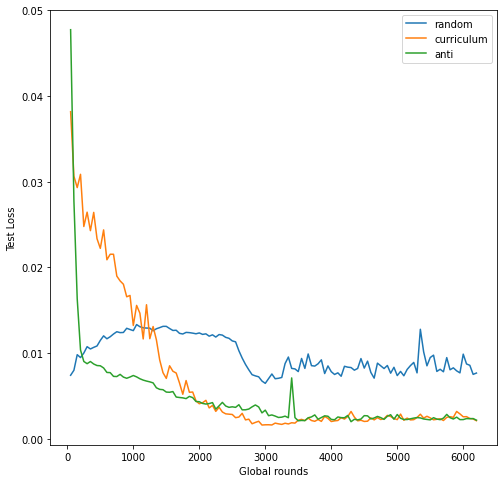

In [67]:

import matplotlib.pyplot as plt
def plot_metrics(results):
  for metrics in results:
    curr = metrics["curriculum"]
    train_acc = metrics["train_accuracy"]
    test_acc = metrics["test_loss"]
    batch = metrics["batch"]
    print(len(test_acc))
    plt.figure(2,figsize=(8, 8))
    plt.plot(batch, test_acc, label = metrics["curriculum"])
    plt.legend(loc='best')
    plt.ylabel('Test Loss')
    plt.xlabel('Global rounds')
  plt.show

plot_metrics(results)